## Import Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import gensim

In [2]:
train = pd.read_csv('data_fix_banget.csv')
train.head()

,label,tweet
0,love,!rp hai ele. Maaf ya gua ga romantis. Gua cuma...
1,anger,"""Mka.a jgn ngatain org klu gmau dikatain...jag..."
2,joy,# CONGRATULATIONS # Mengucapkan selamat untuk ...
3,joy,#Allhamdulilah Bertambah usia lagi jagoan keci...
4,sadness,"#Bali, tunggu koko lagi ya. Koko bakal balik l..."


In [3]:
# Shuffle the rows
train = train.sample(frac=1).reset_index(drop=True)

print(train)

         label                                              tweet
0      sadness                  Saya merasa sangat sedih sekarang
1        anger  Saya sering merasa tidak puas dengan diskusi s...
2         love  aku memilihmu bukan karna aku sayang kamu. Dan...
3         fear  Saya tidak merasa terancam sama sekali oleh or...
4         fear  Saya juga masih percaya pada feminisme dan say...
...        ...                                                ...
21128  sadness  Saya melihat ke cermin akhir-akhir ini, saya p...
21129  sadness  Saya merasa tidak diinginkan atau tidak nyaman...
21130  sadness  Saya bergantian antara menebang optimis dan me...
21131  sadness  Saat kamu merasakan kekosongan di dalam dirimu...
21132      joy  Saya merasa gaya yang kuat warna garis hitam t...

[21133 rows x 2 columns]


In [4]:
train = train[["label", "tweet"]]
train

,label,tweet
0,sadness,Saya merasa sangat sedih sekarang
1,anger,Saya sering merasa tidak puas dengan diskusi s...
2,love,aku memilihmu bukan karna aku sayang kamu. Dan...
3,fear,Saya tidak merasa terancam sama sekali oleh or...
4,fear,Saya juga masih percaya pada feminisme dan say...
...,...,...
21128,sadness,"Saya melihat ke cermin akhir-akhir ini, saya p..."
21129,sadness,Saya merasa tidak diinginkan atau tidak nyaman...
21130,sadness,Saya bergantian antara menebang optimis dan me...
21131,sadness,Saat kamu merasakan kekosongan di dalam dirimu...


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21133 entries, 0 to 21132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   21133 non-null  object
 1   tweet   21133 non-null  object
dtypes: object(2)
memory usage: 330.3+ KB


In [6]:
train.describe()

,label,tweet
count,21133,21133
unique,5,20577
top,joy,Aku merasa seperti aku harus melepaskan rasa m...
freq,5987,5


In [7]:
train.describe(include="O")

,label,tweet
count,21133,21133
unique,5,20577
top,joy,Aku merasa seperti aku harus melepaskan rasa m...
freq,5987,5


In [8]:
train.groupby(by="label").count()

,tweet
label,
anger,4209
fear,3586
joy,5987
love,1859
sadness,5492


In [9]:
train['num_label'] = train['label'].map({'anger':0, 'fear':1, 'joy':2, 'love':2, 'sadness':3})
train.head()

,label,tweet,num_label
0,sadness,Saya merasa sangat sedih sekarang,3
1,anger,Saya sering merasa tidak puas dengan diskusi s...,0
2,love,aku memilihmu bukan karna aku sayang kamu. Dan...,2
3,fear,Saya tidak merasa terancam sama sekali oleh or...,1
4,fear,Saya juga masih percaya pada feminisme dan say...,1


In [10]:
train.groupby(by="num_label").count()

,label,tweet
num_label,,
0,4209,4209
1,3586,3586
2,7846,7846
3,5492,5492


In [11]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

## Data Preprocessing

In [12]:
# !pip install emoji
# !pip install python-crfsuite

In [13]:
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import CRFTagger
excelstopwords = pd.read_excel('stopwords.xlsx')
kamusalay= pd.read_csv("kamusalay.csv")

In [14]:
def lowercase(review):
    return review.lower() #dari python langsung, bkn dari external library

# hapus URL
def remove_url(review):
    return re.sub(r'http\S+', '', review)

#KAMUS ALAY
def alay(review):
    alay_dic = kamusalay.to_dict()
    alay_dic = dict(zip(kamusalay.iloc[:,0], kamusalay.iloc[:,1]))
    words = review.split()
    for i in range(len(words)):
        word = words[i]
        if word in alay_dic.keys():
            words[i] = alay_dic[word]
    sentence = " ".join(words)
    return sentence

def remove_square_brackets(review):
    # Menghapus teks di dalam kurung siku beserta kurungnya
    return re.sub(r'\[.*?\]', '', review)

# hapus irrelevant char(angka, simbol, tanda baca)
def remove_irrelevant(review):
    return re.sub('[^a-zA-Z\s]', ' ', review)

# hapus spasi lebih dari 1
def remove_space(review):
    review= re.sub(r'\s+', ' ', review)
    review= review.replace('\n', ' ')
    review= review.replace('\\n', ' ')
    review= review.replace('\t', ' ')
    review= review.replace('\\t', ' ')
    review= review.replace('\\u', ' ')
    review= review.replace('\\', ' ')
    return review

# hapus emoji
def remove_emoji(review):
    emoji_pattern= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticon
                           u"\U0001F300-\U0001F5FF"  # simbol & dingbat
                           u"\U0001F680-\U0001F6FF"  # transportasi & simbol map
                           u"\U0001F700-\U0001F77F"  # simbol kuno
                           u"\U0001F780-\U0001F7FF"  # simbol kuno tambahan
                           u"\U0001F800-\U0001F8FF"  # simbol tanda batas
                           u"\U0001F900-\U0001F9FF"  # emoticon tambahan
                           u"\U0001FA00-\U0001FA6F"  # simbol musik
                           u"\U0001FA70-\U0001FAFF"  # simbol musik tambahan
                           u"\U00002702-\U000027B0"  # simbol karakter
                           u"\U000024C2-\U0001F251"  # simbol katakter tambahan
                           "]+", flags= re.UNICODE)
    return emoji_pattern.sub(r'', review)


#REMOVING REPEAT CHARACTER
def repeat_char(review):
    review= re.sub('([A-Za-z])\\1{2,}','\\1', review)
    return review


#STOPWORD ENGLISH --> NEED TO FIX
def remove_stopwords(sentence):
    stopwords_list = list(excelstopwords['stopwords'])
    words = sentence.split()
    no_words = [w for w in words if w not in stopwords_list]
    sentence = " ".join(no_words)
    return sentence



In [15]:
def df_prep(train):
    train['filtering']= train['tweet'].apply(lowercase)
    train['filtering']= train['filtering'].apply(remove_url)
   # train['filtering']= train['filtering'].apply(alay)
    train['filtering']= train['filtering'].apply(remove_square_brackets)
    train['filtering']= train['filtering'].apply(remove_irrelevant)
    train['filtering']= train['filtering'].apply(remove_space)
    train['filtering']= train['filtering'].apply(remove_emoji)
    train['filtering']= train['filtering'].apply(repeat_char)
    train["filtering"]= train["filtering"].apply(remove_stopwords)
    return train

In [16]:
train = df_prep(train)
train = train[train['filtering'] != ""]
train

,label,tweet,num_label,filtering
0,sadness,Saya merasa sangat sedih sekarang,3,sedih
1,anger,Saya sering merasa tidak puas dengan diskusi s...,0,puas diskusi omong kosong everyone is beautifu...
2,love,aku memilihmu bukan karna aku sayang kamu. Dan...,2,memilihmu karna sayang karna mencintai memilih...
3,fear,Saya tidak merasa terancam sama sekali oleh or...,1,terancam orang orang miliki menit menit berjal...
4,fear,Saya juga masih percaya pada feminisme dan say...,1,percaya feminisme percaya kekuatan penyelamata...
...,...,...,...,...
21128,sadness,"Saya melihat ke cermin akhir-akhir ini, saya p...",3,cermin pikir cantik membosankan
21129,sadness,Saya merasa tidak diinginkan atau tidak nyaman...,3,nyaman oh kecuali menarik gagang pintu pintu b...
21130,sadness,Saya bergantian antara menebang optimis dan me...,3,bergantian menebang optimis ditakdirkan
21131,sadness,Saat kamu merasakan kekosongan di dalam dirimu...,3,merasakan kekosongan dirimu mengisinya hampa e...


In [17]:
train_size = int(len(train['filtering'])*train_split)
train_size

NameError: name 'train_split' is not defined

In [19]:
sentences = train['filtering']
labels = train['num_label']

In [72]:
# grader-required-cell

EMBEDDING_DIM = 200
MAXLEN = 100
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

In [73]:
# grader-required-cell

# GRADED FUNCTION: train_val_split
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """   
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences) * training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    train_labels = labels[0:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [74]:
# grader-required-cell

# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 18957 sentences for training.

There are 18957 labels for training.

There are 2107 sentences for validation.

There are 2107 labels for validation.


In [75]:
# grader-required-cell

# GRADED FUNCTION: fit_tokenizer
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        oov_token (string) - symbol for the out-of-vocabulary token
    
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for oov_token
    tokenizer = Tokenizer(oov_token = OOV_TOKEN)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [76]:
# grader-required-cell
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Test your function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 24091 words

<OOV> token included in vocabulary

index of word 'i' should be 133


In [77]:
# grader-required-cell

# GRADED FUNCTION: seq_pad_and_trunc
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): maximum length of the token sequence
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded to the same length
    """     
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding = padding, maxlen=maxlen, truncating = truncating)
    
    ### END CODE HERE
    
    return pad_trunc_sequences

In [78]:
# grader-required-cell

# Test your function
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (18957, 100)

Padded and truncated validation sequences have shape: (2107, 100)


In [79]:
# grader-required-cell

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [80]:
from gensim.models import Word2Vec

# Define path to file containing the embeddings
path = './idwiki_word2vec_200.model'

# Load Word2Vec model
id_w2v = Word2Vec.load(path)

# Convert Word2Vec model to dictionary format
W2V_EMBEDDINGS = {word: id_w2v.wv[word] for word in id_w2v.wv.index_to_key}


In [81]:
W2V_EMBEDDINGS['sedih']

array([-1.12498724e+00,  1.78106499e+00,  2.21870852e+00, -2.13177514e+00,
       -8.24971914e-01, -2.96664310e+00,  2.28853965e+00, -2.77335178e-02,
       -1.32273424e+00, -3.67148101e-01,  2.82457948e-01,  2.52194643e-01,
       -4.12005693e-01, -1.30563223e+00, -2.70548668e-02,  3.11934304e+00,
       -1.81374952e-01,  9.39187407e-01,  2.89249182e-01, -5.81449568e-01,
        1.06149864e+00,  3.65803063e-01, -4.12466079e-01,  7.06683457e-01,
        3.01595306e+00, -2.07965061e-01, -1.12384176e+00, -7.90287793e-01,
       -3.20876539e-02, -1.84497011e+00, -3.96469802e-01, -8.43199968e-01,
        1.53188454e-03, -1.53308618e+00,  1.82919359e+00, -6.94898784e-01,
        1.25896037e+00,  1.48273826e+00,  7.38302827e-01,  1.03005362e+00,
        6.35388255e-01,  2.04106474e+00, -8.45633805e-01, -1.04670572e+00,
        1.09358275e+00,  1.33823287e+00,  1.92231643e+00, -2.73456395e-01,
        1.73442960e+00,  1.82751822e+00, -5.67157865e-02,  9.65922713e-01,
        3.12790066e-01, -

In [82]:
print(id_w2v.wv.most_similar('raja'))

[('rajanya', 0.7246140837669373), ('kerajaan', 0.7116712927818298), ('penguasa', 0.6902537941932678), ('firaun', 0.6767520308494568), ('maharaja', 0.6640602946281433), ('ratu', 0.6389881372451782), ('permaisuri', 0.6085841655731201), ('kaisar', 0.6011759042739868), ('kertanagara', 0.599554181098938), ('pangeran', 0.5947679281234741)]


In [83]:
print(id_w2v.wv.most_similar('aw'))

[('agustawestland', 0.7639529705047607), ('shucks', 0.7140540480613708), ('xr', 0.6768186092376709), ('uh', 0.6572850942611694), ('wn', 0.6447826623916626), ('eurocopter', 0.6371169686317444), ('xh', 0.6359284520149231), ('yh', 0.6301230192184448), ('xw', 0.6284568309783936), ('westland', 0.6271255612373352)]


In [84]:
vector_anjing = id_w2v.wv.get_vector('anjing')
print(vector_anjing)

[-0.6338662   1.1988187   0.6044298  -2.3529801  -2.738229   -0.8941125
 -0.76630354 -1.0421748  -1.3308594   1.5614973  -3.295941    2.3175085
 -0.4453414   0.9909841  -2.1871486  -0.10886392 -0.46935996 -0.8569066
 -2.7155235   1.748261    0.09255172  0.24915007 -0.247211   -1.2128687
  0.4945234   0.085122   -0.09776495 -0.46747953  0.19653408 -0.06401195
 -2.8474798   0.72397166 -1.3340746  -1.7579952  -0.19209948 -1.8071597
  0.47579393 -0.8388059   0.09791803  0.43881267  0.9861907   0.2837769
 -1.0391033  -0.4432146  -1.6438637  -1.817277    1.726094   -0.21734771
 -0.59803456 -2.100845   -0.7878171  -0.6619289   1.1326356   0.10544442
 -1.4301167  -2.223291   -0.06249101  0.5475086  -2.138893   -1.0038075
 -2.045015   -0.4497046  -1.4529423   2.2090106  -0.5785613   0.28845495
 -0.64271146  3.6567655   2.6617074  -0.630098    1.7693353  -1.9331331
  1.0839024  -0.8327269  -2.6705952  -0.33268547 -0.36628118 -1.7663293
 -1.013536   -1.4777486  -0.15575475  2.3521047   0.22323124

In [85]:
# grader-required-cell

# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = W2V_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [86]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=24071, output_dim=200, input_length=max_length, weights=[EMBEDDINGS_MATRIX], trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=24, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='softmax')
])

NameError: name 'max_length' is not defined

In [87]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
        embeddings_matrix (array): predefined weights of the embeddings
    
    Returns:
        model (tf.keras Model): the sentiment classifier model
    """
    ### START CODE HERE
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Dropout(0.2),  # Add dropout layer
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),  # Reduced number of units
        tf.keras.layers.Dropout(0.2),  # Add dropout layer
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    learning_rate = 0.001

    # Compile the model with Adam optimizer and specified learning rate

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])


    ### END CODE HERE

    return model

In [115]:
# grader-required-cell

# Create your untrained model
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)

# Train the model and save the training history
history = model.fit(train_pad_trunc_seq, train_labels, epochs=100, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/100
593/593 [==============================] - 5s 8ms/step - loss: 1.3193 - accuracy: 0.3902 - val_loss: 1.2704 - val_accuracy: 0.4461
Epoch 2/100
593/593 [==============================] - 5s 8ms/step - loss: 1.2483 - accuracy: 0.4953 - val_loss: 1.2201 - val_accuracy: 0.5358
Epoch 3/100
593/593 [==============================] - 5s 8ms/step - loss: 1.2160 - accuracy: 0.5320 - val_loss: 1.1904 - val_accuracy: 0.5714
Epoch 4/100
593/593 [==============================] - 5s 8ms/step - loss: 1.1939 - accuracy: 0.5582 - val_loss: 1.1720 - val_accuracy: 0.5956
Epoch 5/100
593/593 [==============================] - 5s 8ms/step - loss: 1.1827 - accuracy: 0.5646 - val_loss: 1.1595 - val_accuracy: 0.6056
Epoch 6/100
593/593 [==============================] - 5s 9ms/step - loss: 1.1733 - accuracy: 0.5736 - val_loss: 1.1507 - val_accuracy: 0.6103
Epoch 7/100
593/593 [==============================] - 5s 8ms/step - loss: 1.1665 - accuracy: 0.5799 - val_loss: 1.1450 - val_accuracy: 0.6108

Epoch 58/100
593/593 [==============================] - 5s 9ms/step - loss: 1.1169 - accuracy: 0.6182 - val_loss: 1.0951 - val_accuracy: 0.6440
Epoch 59/100
593/593 [==============================] - 5s 8ms/step - loss: 1.1179 - accuracy: 0.6181 - val_loss: 1.0954 - val_accuracy: 0.6440
Epoch 60/100
593/593 [==============================] - 4s 7ms/step - loss: 1.1208 - accuracy: 0.6150 - val_loss: 1.0945 - val_accuracy: 0.6488
Epoch 61/100
593/593 [==============================] - 5s 9ms/step - loss: 1.1119 - accuracy: 0.6246 - val_loss: 1.0943 - val_accuracy: 0.6426
Epoch 62/100
593/593 [==============================] - 5s 9ms/step - loss: 1.1144 - accuracy: 0.6216 - val_loss: 1.0952 - val_accuracy: 0.6478
Epoch 63/100
593/593 [==============================] - 5s 8ms/step - loss: 1.1157 - accuracy: 0.6218 - val_loss: 1.0929 - val_accuracy: 0.6488
Epoch 64/100
593/593 [==============================] - 5s 8ms/step - loss: 1.1182 - accuracy: 0.6173 - val_loss: 1.0944 - val_accuracy:

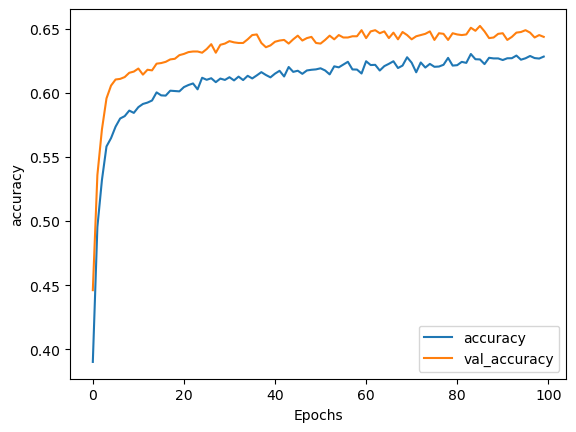

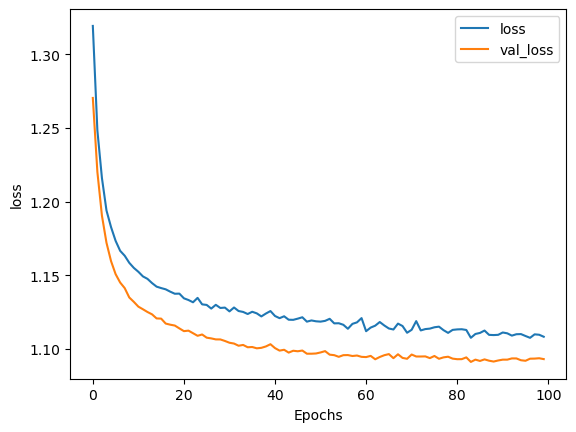

In [116]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [117]:
text = ''"Brosis, hari ini gue lagi on the way ke kampus bareng pacar, tiba-tiba ada anjing yang ngejar-ngejar gue, bikin deg-degan banget, ya Allah! Trus pas nyampe kampus, parkiran full banget, sampe gue sama pacar muter-muter gak dapet-dapet tempat parkir. Akhirnya, kita berdua telat masuk kelas deh! Pas udah masuk, dosen langsung nyerocos ngomel-ngomel gara-gara telat. Capek banget hari ini, apalagi sama pacar."
text

'Brosis, hari ini gue lagi on the way ke kampus bareng pacar, tiba-tiba ada anjing yang ngejar-ngejar gue, bikin deg-degan banget, ya Allah! Trus pas nyampe kampus, parkiran full banget, sampe gue sama pacar muter-muter gak dapet-dapet tempat parkir. Akhirnya, kita berdua telat masuk kelas deh! Pas udah masuk, dosen langsung nyerocos ngomel-ngomel gara-gara telat. Capek banget hari ini, apalagi sama pacar.'

In [118]:
#data test preprocessing

def prep_test(review):
    review = lowercase(review)
    review = remove_url(review)
    review = remove_irrelevant(review)
    review = remove_space(review)
    review = remove_emoji(review)
    review = repeat_char(review)
    review = remove_stopwords(review)
    text = [review]
    inference_sequences = tokenizer.texts_to_sequences(text)
    inference_padded = pad_sequences(inference_sequences, padding=PADDING, maxlen=MAXLEN)
    return inference_padded

In [119]:
test_padded = prep_test(text)
test_padded

array([[   1,    8,  858,  223, 2994, 1169,  553,  347,  360, 4011, 4011,
           8,   42,  773, 1734,   16,    6,   77,  204,   46, 1507, 1169,
        3636, 2675,   16,   64,    8,  347, 1824, 1824,   21,  406,  406,
        1592,  714, 1231,   80,  140,  153,   46,   18,   80, 1902,  114,
           1, 3666, 3666,  388,  388, 1231, 1115,   16,  347,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])

In [120]:
def prediction(test):
    label = ["anger", "fear", "joy", "sadness"]
    result = model.predict(test)
    index = np.argmax(result)
    hasil = label[index]
    return hasil

In [121]:
prediction(test_padded)

'anger'

In [122]:
model.predict(test_padded)

array([[0.60030115, 0.09688536, 0.29743972, 0.00537383]], dtype=float32)

In [123]:
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

NameError: name 'valdata' is not defined

In [124]:
result = model.predict(val_pad_trunc_seq)

In [125]:
result

array([[9.26537693e-01, 7.27185607e-02, 8.62528668e-06, 7.35203328e-04],
       [3.46267503e-03, 1.81858707e-06, 9.96113181e-01, 4.22219717e-04],
       [1.04636624e-01, 4.11395740e-04, 6.10582352e-01, 2.84369677e-01],
       ...,
       [6.91930545e-05, 1.10287256e-05, 9.98487949e-01, 1.43177912e-03],
       [1.57163490e-03, 7.68191123e-04, 8.53588060e-03, 9.89124298e-01],
       [1.17442153e-06, 4.57028027e-10, 9.99998808e-01, 1.70044090e-09]],
      dtype=float32)

In [126]:
# Get the index of the maximum probability for each row
predicted_labels = np.argmax(result, axis=1)
predicted_labels

array([0, 2, 2, ..., 2, 3, 2], dtype=int64)

In [128]:
len(predicted_labels)

2107

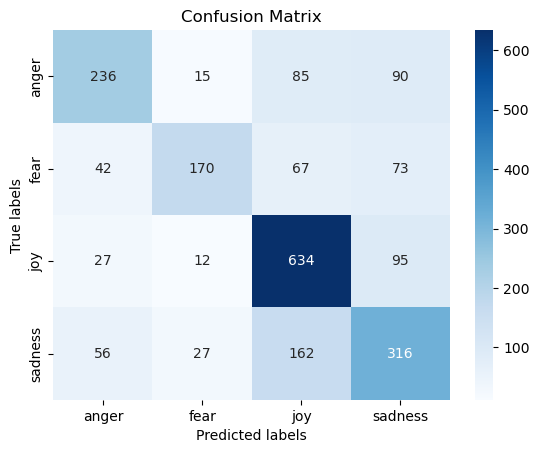

In [127]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_true contains the true labels and y_pred contains the predicted labels
# Replace y_true and y_pred with your actual data
y_true = np.array(val_labels) # True labels
y_pred = predicted_labels  # Predicted labels

# Create the confusion matrix
label = ["anger", "fear", "joy", "sadness"]
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, cmap="Blues", annot = True, fmt='d', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [129]:
# Assuming you have true labels stored in 'true_labels' and predicted labels stored in 'predicted_labels'

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print accuracy
print("Accuracy:", accuracy)


Accuracy: 0.6435690555291884
